# Models comparison

Prerequisite: train the models you want to evaluate. Run > `python train.py --model <model_name>`


In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

from sklearn import metrics
from scipy.stats import entropy

import ujson as json

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set default size to display larger figures
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
# to import from parent directory
import os
import sys
module_path = os.path.abspath(os.path.join('../models'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# import models to compare
from ML_models import NaiveBayes

## Models comparison script

It computes the following metrics:
- overall accuracy
- f1-score: computed globally by counting the total true positives, false negatives and false positives
- mean absolute error (MAE)
- KL-divergence (with logarithm base of 10): divergence of P from Q

It plots:
- confusion matrix
- predicted class distribution

References:
- f1-score in sklearn.metrics: [how is it computed?](https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult)

In [5]:
# ADAPTED FROM: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

def highlight_best(data, best_direction={}, best_color='green', worst_color='red'):
    '''Highlight the best and worst column values in a DataFrame
    
    Args:
        'data' (pd.Series or pd.DataFrame): dataset
        'best_direction' (dict: String -> bool): indicate whether a maximum (True) or a minimum (False) is the best column value
        'color' (String): color of the highlight
    
    Return:
        'style_mask' (list or pd.Dataframe): dataset with best column values highlighted
    
    Remark:
        If used with '.apply(axis=0)': the mask is computed column per column, 'data' is a pd.Series and 'style_mask' is a list
        If used with '.apply(axis=None)': the mask is on the whole pd.DataFrame 'data' and 'style_mask' is a pd.DataFrame
    '''
    best_attr = "background-color: {}".format(best_color)
    worst_attr = "background-color: {}".format(worst_color)
        
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        is_min = data == data.min()
        style_mask = [(ismax[i]*best_attr) + (ismin[i]*best_attr) + ""]
    
    else:  # from .apply(axis=None)
        best = [np.max(data[column_name]) if best_direction.get(column_name, True) else np.min(data[column_name]) for column_name in data.columns]
        is_best = data.eq(best)
        
        worst = [np.min(data[column_name]) if best_direction.get(column_name, True) else np.max(data[column_name]) for column_name in data.columns]
        is_worst = data.eq(worst)
        
        style_mask = pd.DataFrame(np.core.defchararray.add(np.where(is_best, best_attr, ""), np.where(is_worst, worst_attr, "")), index=data.index, columns=data.columns)
        
    return style_mask

In [6]:
def class_distribution(y_pred_list, fig_legend, grade2class):
    """Plot an histogram of the class distribution from the model(s)
    """        
    # input type cleanup to match expected type
    if not isinstance(y_pred_list, list):
        y_pred_list = [y_pred_list]
        
    # class distribution
    class_min = min(grade2class.values())
    class_max = max(grade2class.values())
    
    # plot histogram
    plt.hist(y_pred_list, bins = range(class_min, class_max+2), density=True, histtype='bar')
    plt.legend(fig_legend)
    plt.xticks(list(grade2class.values()), list(grade2class.keys()))
    plt.xlabel("Grade")
    plt.ylabel("Frequency")
    plt.title("Class distribution")
    plt.show()
    # print class distribution
    for k, subset_name in enumerate(fig_legend):
        y_pred_filtered = y_pred_list[k][y_pred_list[k] != -1]
        grade2freq = {grade: round(y_pred_filtered[y_pred_filtered==grade2class[grade]].shape[0]/y_pred_filtered.shape[0]*100, 1) for grade in grade2class.keys()}
        print("Distribution of classes in {} :\n{}".format(subset_name, grade2freq))

In [7]:
# ADAPTED FROM: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(y_true, y_pred, classes, model_name, split, normalize=True, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Title
    title = "confusion matrix for the {} model on the {}-set".format(model_name, split)
    
    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        title = "Normalized " + title
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [8]:
def models_comparison(models_pred_dict, y, grade2class, split="val", y_user=None, displayNaive=True, isHighlight=True, printCM=False):
    # input type cleanup to match expected type
    if isinstance(models_pred_dict, list):
        models_pred_dict = {"model " + str(i): model for i, model in enumerate(models_pred_dict)}
    elif not isinstance(models_pred_dict, dict):
        models_pred_dict = {"your model": models_pred_dict}
    
    # metrics of interest
    metrics_dict = {"Accuracy": True, "MAE":False, "F1-score":True, "KL_divergence":False}
    
    # true class distribution
    p_true = [np.sum(y == c)/y.shape[0] for c in grade2class.values()]
    
    models_distribution = {}
    
    for model_name in models_pred_dict.keys():
        # class prediction
        y_pred = models_pred_dict[model_name]
        # predicted class distribution
        p_pred = [np.sum(y_pred == c)/y.shape[0] for c in grade2class.values()]
        models_distribution[model_name] = p_pred
        
    # naive approach: predict most common class
    if displayNaive:
        naive_name = "Naive"
        # class prediction
        y_pred = [np.argmax(p_true)]*len(y)
        models_pred_dict[naive_name] = y_pred
        # predicted class distribution
        p_pred = [np.sum(y_pred == c)/y.shape[0] for c in grade2class.values()]
        models_distribution[naive_name] = p_pred

    # table summarizing the metrics for each model
    metrics_table = pd.DataFrame(data={"Accuracy": [metrics.accuracy_score(y, y_pred)*100 for y_pred in models_pred_dict.values()],
                           "F1-score": [metrics.f1_score(y, y_pred, average='macro') for y_pred in models_pred_dict.values()],
                           "MAE": [metrics.mean_absolute_error(y, y_pred) for y_pred in models_pred_dict.values()],
                            "KL_divergence": [entropy(p_pred, p_true, base=10) for p_pred in models_distribution.values()]},
                          index=models_pred_dict.keys())
    metrics_table = metrics_table[list(metrics_dict.keys())]    
        
    # sort in decreasing accuracy score
    #metrics_table.sort_values(by=["Accuracy", "F1-score", "MAE", "KL_divergence"], axis=0, ascending=False, inplace=True)

    # highlights the best values
    if isHighlight:
        display(metrics_table.style.apply(lambda data: highlight_best(data, best_direction=metrics_dict), axis=None).format("{:.2f}"))
    else:
        display(metrics_table)

    # user assigned grades
    if not y_user is None:
        user_label = "user assigned grades"
        # filter examples with user assigned grades
        y_filtered = y[y_user != -1]
        y_user_filtered = y_user[y_user != -1]
        # user class distribution
        p_user = [np.sum(y_user_filtered == c)/y_filtered.shape[0] for c in grade2class.values()]
        # metrics
        user_metrics = {"Accuracy": metrics.accuracy_score(y_filtered, y_user_filtered)*100,
                        "F1-score": metrics.f1_score(y_filtered, y_user_filtered, average='macro'),
                        "MAE": metrics.mean_absolute_error(y_filtered, y_user_filtered),
                        "KL_divergence": entropy(p_user, p_true)}
        print("User assigned grades metrics: \n", user_metrics)
    
    # plot the class distribution of the best model
    best_model_name = metrics_table['Accuracy'].argmax()
    
    # plot the class distribution of the vanilla model
    vanilla_name_list = [key for key in models_pred_dict.keys() if "vanilla" in key]
    if len(vanilla_name_list) > 0:
        y_pred_list = [y, models_pred_dict[vanilla_name_list[0]], models_pred_dict[best_model_name]]
        fig_legend = ["True class distribution", vanilla_name_list[0], best_model_name]
    else:
        y_pred_list = [y, models_pred_dict[best_model_name]]
        fig_legend = ["True class distribution", best_model_name]    
    if not y_user is None:
        y_pred_list.append(y_user)
        fig_legend.append(user_label)
    
    class_distribution(y_pred_list, fig_legend, grade2class)
    
    # plot the confusion matrix of the best model
    if printCM:
        plot_confusion_matrix(y, models_pred_dict[best_model_name], grade2class.keys(), best_model_name, split)


## Naive Bayes tuning

Tune the weighting scheme on the validation set.

To account for imbalance, each example $x^{(i)}$ is reweighted according to the class $y^{(i)}$ it belongs to:

$w(x^{(i)}) = \frac{1}{p^{y^{(i)}}}$

Where: $p^{y^{(i)}}$ is the fraction of training examples that are in class $y^{(i)}$.
(Or equivalently, the fraction of validation examples, as the split was done in order to preserve the class distribution in each set).

In [9]:
def NB_tuning(MBversion=2016, ppDirName="../data/binary"):
    MBversion = str(MBversion)
    print("{:-^100}".format("Naive Bayes weighting scheme tuning, on MoonBoard version {}".format(MBversion)))
    
    # path to the data
    ppVersionDirName = os.path.join(ppDirName, MBversion)
    # import the data
    X_train = np.load(os.path.join(ppVersionDirName, "X_train.npy"))
    y_train = np.load(os.path.join(ppVersionDirName, "y_train.npy"))
    X_val = np.load(os.path.join(ppVersionDirName, "X_val.npy"))
    y_val = np.load(os.path.join(ppVersionDirName, "y_val.npy"))
    y_user_val = np.load(os.path.join(ppVersionDirName, "y_user_val.npy"))
    with open(os.path.join(ppVersionDirName, "grade2class.json")) as json_file:  
        grade2class = json.load(json_file)
    
    # true class distribution
    p_true = {c: np.sum(y_val == c)/y_val.shape[0] for c in set(y_val)}
    
    # weighting parameter to tune
    k_list = range(1, 10)
    # create the models
    models_dict = {"NB with HP k="+str(k): NaiveBayes(weights={c: 1./p**k for c, p in p_true.items()}) for k in k_list}
    models_dict["vanilla NB (k=0)"] = NaiveBayes()

    models_pred_dict = {}
    # train the models
    for model_name, model in models_dict.items():
        model.fit(X_train, y_train)
        # class prediction
        models_pred_dict[model_name] = models_dict[model_name].predict(X_val)
        
    # compare the models
    models_comparison(models_pred_dict, y_val, grade2class, y_user=y_user_val)
    

-------------------Naive Bayes weighting scheme tuning, on MoonBoard version 2016-------------------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/c

,Accuracy,MAE,F1-score,KL_divergence
NB with HP k=1,32.26,2.23,0.05,0.39
NB with HP k=2,32.73,2.12,0.05,0.34
NB with HP k=3,33.69,1.98,0.06,0.29
NB with HP k=4,35.08,1.78,0.08,0.21
NB with HP k=5,36.81,1.60,0.11,0.12
NB with HP k=6,37.06,1.60,0.13,0.08
NB with HP k=7,33.32,2.17,0.15,0.22
NB with HP k=8,26.06,3.54,0.12,0.61
NB with HP k=9,18.42,5.26,0.09,1.13
vanilla NB (k=0),32.18,2.30,0.04,0.42


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


User assigned grades metrics: 
 {'Accuracy': 97.34675205855444, 'F1-score': 0.8554477791333436, 'MAE': 0.04117108874656908, 'KL_divergence': 0.11228408456643847}


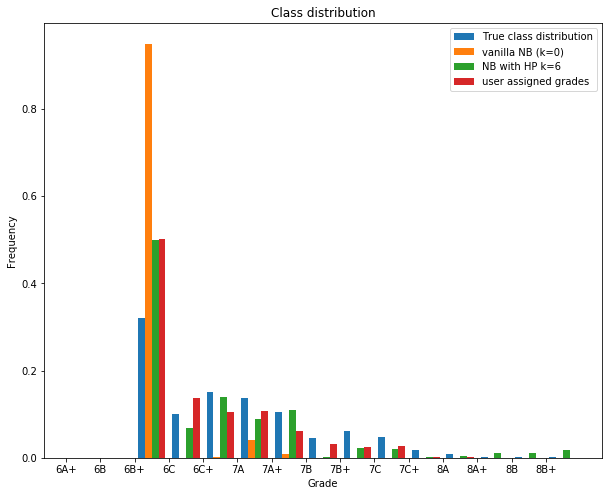

Distribution of classes in True class distribution :
{'6A+': 0.0, '6B': 0.0, '6B+': 32.0, '6C': 10.1, '6C+': 15.1, '7A': 13.8, '7A+': 10.5, '7B': 4.6, '7B+': 6.1, '7C': 4.8, '7C+': 1.7, '8A': 0.8, '8A+': 0.3, '8B': 0.1, '8B+': 0.1}
Distribution of classes in vanilla NB (k=0) :
{'6A+': 0.0, '6B': 0.0, '6B+': 94.9, '6C': 0.0, '6C+': 0.1, '7A': 4.2, '7A+': 0.8, '7B': 0.0, '7B+': 0.0, '7C': 0.0, '7C+': 0.0, '8A': 0.0, '8A+': 0.0, '8B': 0.0, '8B+': 0.0}
Distribution of classes in NB with HP k=6 :
{'6A+': 0.0, '6B': 0.0, '6B+': 49.9, '6C': 6.9, '6C+': 14.0, '7A': 9.0, '7A+': 11.0, '7B': 0.2, '7B+': 2.2, '7C': 1.9, '7C+': 0.3, '8A': 0.4, '8A+': 1.2, '8B': 1.1, '8B+': 1.8}
Distribution of classes in user assigned grades :
{'6A+': 0.0, '6B': 0.0, '6B+': 50.0, '6C': 13.7, '6C+': 10.5, '7A': 10.7, '7A+': 6.2, '7B': 3.2, '7B+': 2.6, '7C': 2.7, '7C+': 0.3, '8A': 0.1, '8A+': 0.0, '8B': 0.0, '8B+': 0.0}


In [10]:
NB_tuning()

## End-to-end CNN evaluation

The end-to-end CNN is evaluated on the validation set.

In [11]:
# CNN evaluation script
def CNN_evaluation(pred_path, test_split="val", MBversions=[2016, 2017], ppDirName="../data/binary", printCM=False):
    MBversions = [str(MBversion) for MBversion in MBversions]
    print("{:-^100}".format("CNN evaluation on {}-set, on MoonBoard versions {}".format(test_split, MBversions)))

    with open(os.path.join(ppDirName, "2016", "grade2class.json")) as json_file:  
        grade2class = json.load(json_file)
    
    # load the true labels
    y_test = np.load(os.path.join(pred_path, "{}_true.npy".format(test_split)))
    # load the predicted validation labels
    y_pred = np.load(os.path.join(pred_path, "{}_predictions.npy".format(test_split)))
    models_pred_dict = {"End-to-end CNN": y_pred}
    
    # compare the models
    models_comparison(models_pred_dict, y_test, grade2class, split=test_split, isHighlight=False, printCM=printCM)
    

-----------------CNN evaluation on val-set, on MoonBoard versions ['2016', '2017']------------------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


,Accuracy,MAE,F1-score,KL_divergence
End-to-end CNN,39.902831,1.171314,0.172880,0.12019
Naive,24.588086,2.416984,0.026314,NaN


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


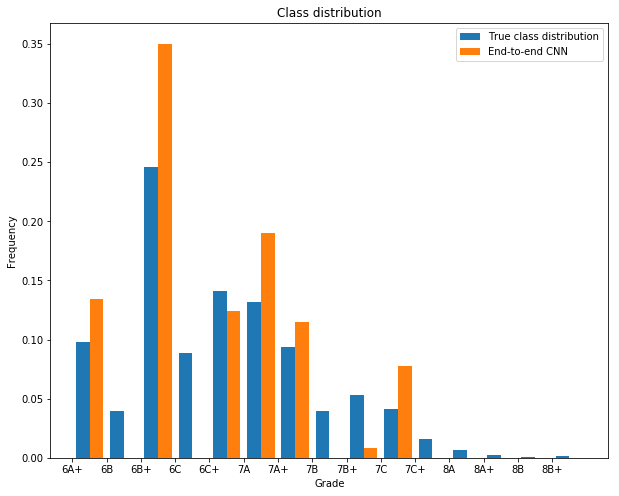

Distribution of classes in True class distribution :
{'6A+': 9.8, '6B': 4.0, '6B+': 24.6, '6C': 8.9, '6C+': 14.1, '7A': 13.2, '7A+': 9.4, '7B': 4.0, '7B+': 5.3, '7C': 4.1, '7C+': 1.6, '8A': 0.7, '8A+': 0.2, '8B': 0.1, '8B+': 0.1}
Distribution of classes in End-to-end CNN :
{'6A+': 13.5, '6B': 0.0, '6B+': 35.0, '6C': 0.0, '6C+': 12.4, '7A': 19.0, '7A+': 11.5, '7B': 0.0, '7B+': 0.9, '7C': 7.7, '7C+': 0.0, '8A': 0.0, '8A+': 0.0, '8B': 0.0, '8B+': 0.0}


In [12]:
# path to the predicted validation labels
pred_path = "../save/test/ImageClimbCNN-new-01"
# evaluation on the validation set
CNN_evaluation(pred_path, test_split="val", printCM=False)

## Best model evaluation

The best model is the end-to-end CNN.

It is evaluated on the test set.

-----------------CNN evaluation on test-set, on MoonBoard versions ['2016', '2017']-----------------


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2507: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=0)


,Accuracy,MAE,F1-score,KL_divergence
End-to-end CNN,39.945078,1.209759,0.170217,0.116633
Naive,24.588086,2.416984,0.026314,NaN


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


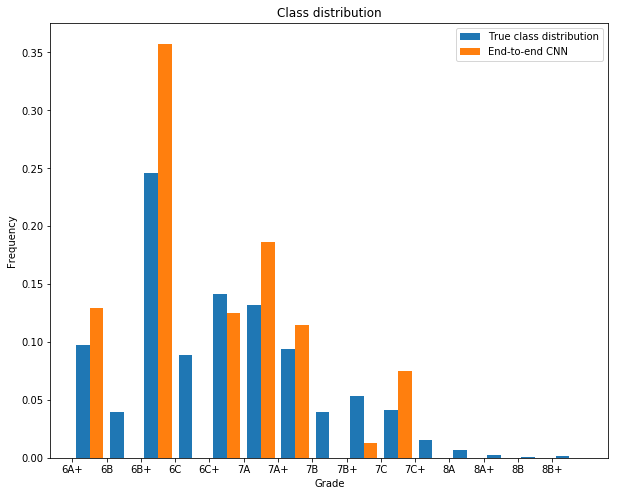

Distribution of classes in True class distribution :
{'6A+': 9.8, '6B': 4.0, '6B+': 24.6, '6C': 8.9, '6C+': 14.1, '7A': 13.2, '7A+': 9.4, '7B': 4.0, '7B+': 5.3, '7C': 4.1, '7C+': 1.6, '8A': 0.7, '8A+': 0.2, '8B': 0.1, '8B+': 0.1}
Distribution of classes in End-to-end CNN :
{'6A+': 12.9, '6B': 0.0, '6B+': 35.8, '6C': 0.0, '6C+': 12.5, '7A': 18.6, '7A+': 11.4, '7B': 0.0, '7B+': 1.2, '7C': 7.5, '7C+': 0.0, '8A': 0.0, '8A+': 0.0, '8B': 0.0, '8B+': 0.0}


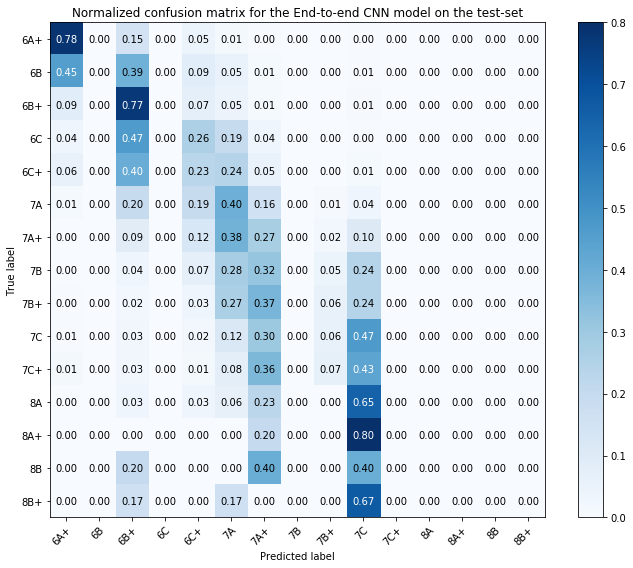

In [13]:
# path to the predicted validation labels
pred_path = "../save/test/ImageClimbCNN-new-02"
# evaluation on the validation set
CNN_evaluation(pred_path, test_split="test", printCM=True)